# Interpolate with downstream distance 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()

In [3]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
def add_dice_thickndx(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dice_thickn' and 'dice_thickndx' to the geodataframe
    """
    
    gdf['dice_thickn'] = gdf.ice_thickn.diff().copy()
        
    gdf['dice_thickndx'] = gdf.dice_thickn.to_numpy()/gdf.dx.to_numpy()

In [4]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)
    add_distance_to_gdf(ll[line])
    add_dice_thickndx(ll[line])
    

In [5]:
#NB add line8
cross_channel_lines = ['line8', 'line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1','line0']


In [6]:
#lines which cross the channel, (ll restricted to the above subset)
cl  = {key:ll[key] for key in cross_channel_lines}

### next do channel edges

In [7]:
# find the point at the edge of each channel, where dice_thickndx is over a certain threshold
channel_lmr = {} #left mid right
for key,value in cl.items():
    try:
        channel_lmr[key] = [value[abs(value.dice_thickndx) > 2].index[0],
                          value.ice_thickn.idxmin(),
                          value[abs(value.dice_thickndx) > 2].index[-1]]
    except IndexError:
        channel_lmr[key] = [50,50,50]

In [154]:
#manually adjust
channel_lmr['line8'][0]=525
channel_lmr['line8'][1]=530
channel_lmr['line8'][2]=535
channel_lmr['line7p75'][0]=114
channel_lmr['line7p5'][0]=100
channel_lmr['line7p25'][0]=147
channel_lmr['line7'][0]=566
channel_lmr['line6'][0]=544
channel_lmr['line5'][0]=610
channel_lmr['line5'][2]=813
channel_lmr['lineAPREScross'][0]=415
channel_lmr['lineAPREScross'][2]=650
channel_lmr['line4'][0]=710
# channel_lmr['line3'][0]=635 # too wide?
# channel_lmr['line3'][2]=1062
channel_lmr['line3'][0]=719
channel_lmr['line3'][2]=1062
# channel_lmr['line2'][0]=623 #too wide?
# channel_lmr['line2'][2]=883
channel_lmr['line2'][0]=714
channel_lmr['line2'][2]=883
channel_lmr['line1'][0]=530
channel_lmr['line1'][2]=700
channel_lmr['line0'][0]=698
channel_lmr['line0'][2]=885

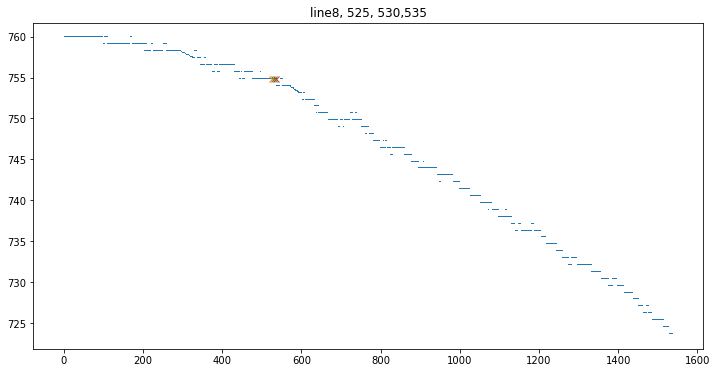

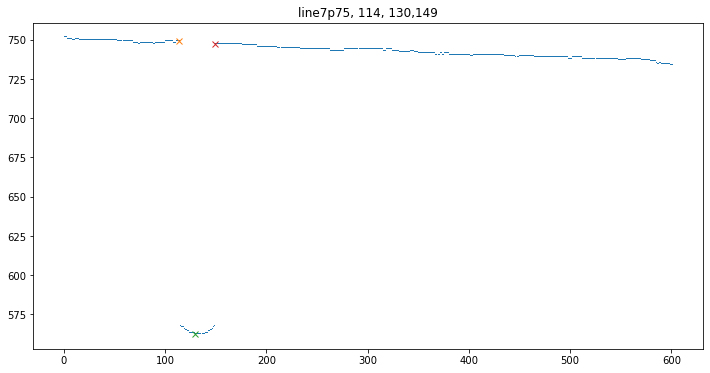

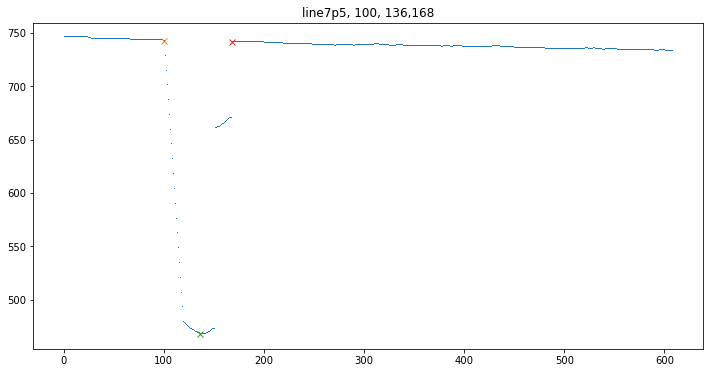

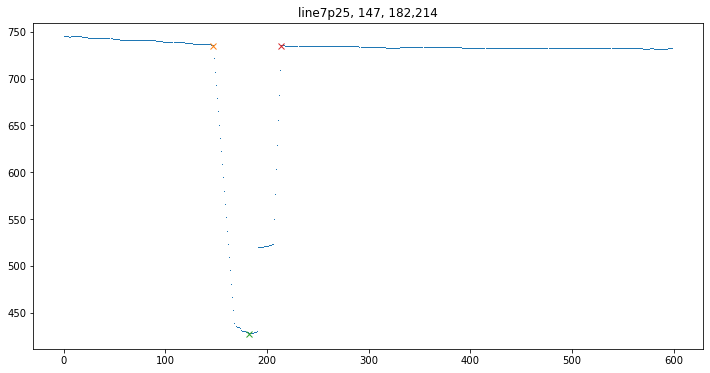

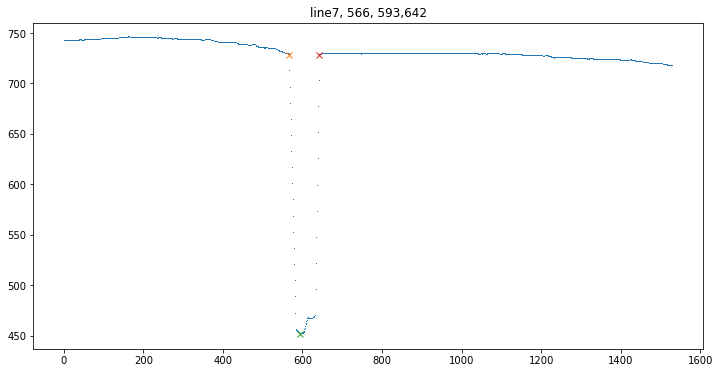

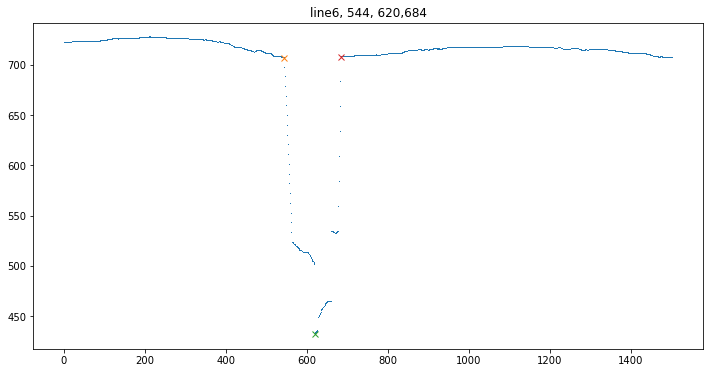

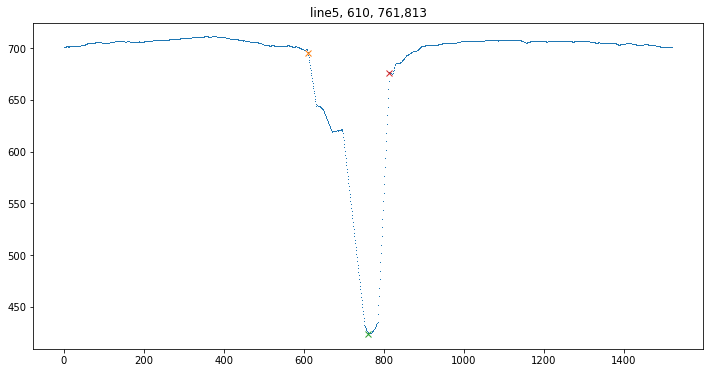

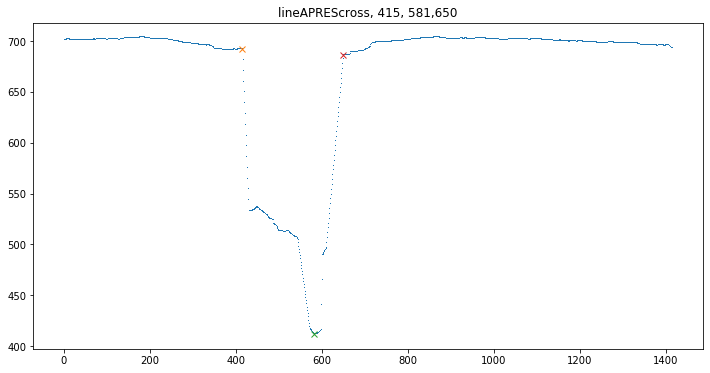

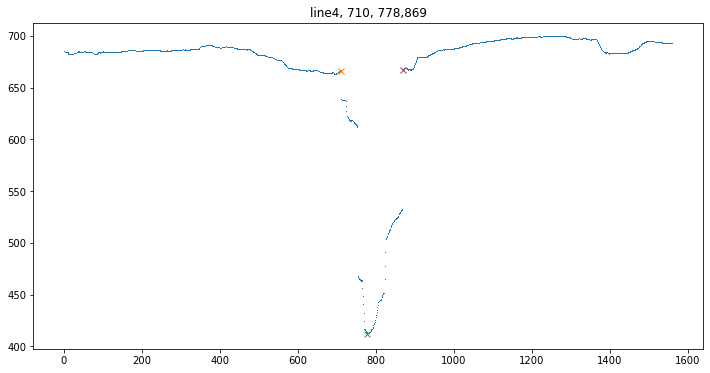

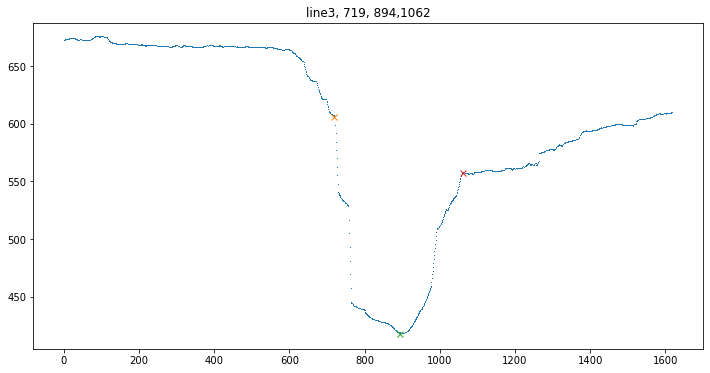

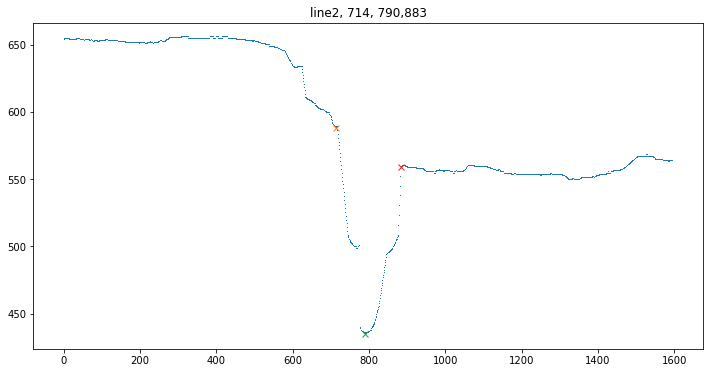

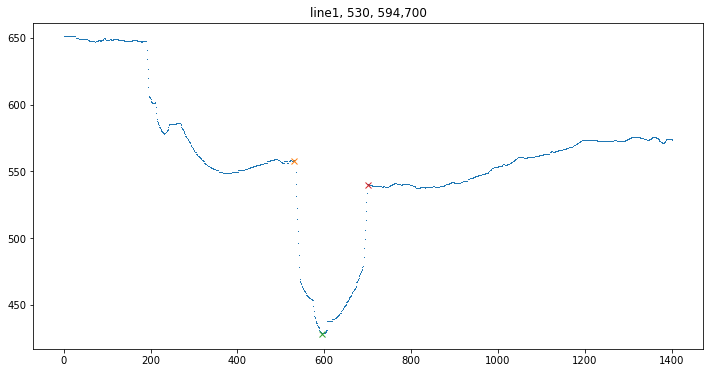

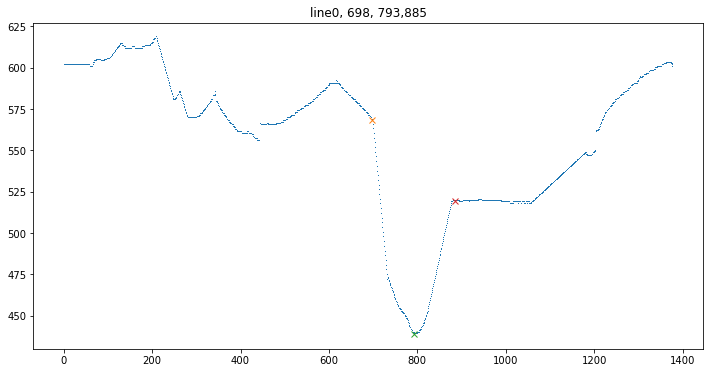

In [155]:
# double check we've picked the right bits.
for key,value in cl.items():
    plt.figure(figsize=(12,6))
    plt.plot(value.ice_thickn,',')
    plt.plot(channel_lmr[key][0],value.loc[channel_lmr[key][0]].ice_thickn,'x')
    plt.plot(channel_lmr[key][1],value.loc[channel_lmr[key][1]].ice_thickn,'x')
    plt.plot(channel_lmr[key][2],value.loc[channel_lmr[key][2]].ice_thickn,'x')
    plt.title(f"{key}, {channel_lmr[key][0]}, {channel_lmr[key][1]},{channel_lmr[key][2]}")
    plt.show()

In [156]:
#get just the channel part of the dataframe
chan_dfs = {}
for key,value in cl.items():
    
    chan_dfs[key] = cl[key].loc[channel_lmr[key][0]:channel_lmr[key][2]] 
#     chan_dfs[key].reset_index(drop=True,inplace=True)


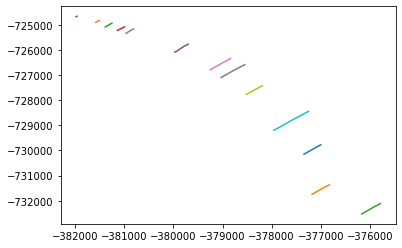

In [157]:
for key,value in chan_dfs.items():
    plt.plot(value.x,value.y)

In [158]:
# add normalised_distance
for line,value in chan_dfs.items():

    #first get distance from left to centre
    left_i = channel_lmr[line][0]
    mid_i = channel_lmr[line][1]
    right_i = channel_lmr[line][2]
    # l2c = left to mid
    dist_l2m = ((chan_dfs[line].distan_cum.loc[left_i:mid_i].copy() - chan_dfs[line].distan_cum.loc[left_i])/
                (2*(chan_dfs[line].distan_cum.loc[mid_i] - chan_dfs[line].distan_cum.loc[left_i])))[:-1]
    #centre to right
    dist_m2r = ((chan_dfs[line].distan_cum.loc[mid_i:right_i].copy() - chan_dfs[line].distan_cum.loc[mid_i])/
                (2*(chan_dfs[line].distan_cum.loc[right_i] - chan_dfs[line].distan_cum.loc[mid_i]))) + 0.5    

    value['normalised_distance'] = pd.concat([dist_l2m,dist_m2r])
    
    value['cross_chan_dist'] = chan_dfs[line].distan_cum - chan_dfs[line].distan_cum.loc[left_i]
    
#     chan_dfs[line]['normalised_distance'] = 
    

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [159]:
def interp_chan(gdf):
    """
    Input: Gdf with 'normalised_dist' as a column
    
    bin the ice thickness & coordinates in the channel
    
    Output: gdf only over the channel, all variables binned to certain cross channel intervals
    """
    
    f_x = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.x  ) #corresponding bins for each point
    f_y = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.y )
    f_ice_thickn = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.ice_thickn)
    f_surf = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.surf)
    f_bed = sp.interpolate.interp1d( gdf.normalised_distance ,gdf.bed)
                           
    cc = np.linspace(0,1,20) #cross channel 
    
    gdf_out = pd.DataFrame({})
    gdf_out['x'] = f_x(cc)
    gdf_out['y'] =  f_y(cc)
    gdf_out['ice_thickn'] = f_ice_thickn(cc)
    gdf_out['surf'] = f_surf(cc)
    gdf_out['bed'] = f_bed(cc)
    
    half_dist_cross_chan = gdf.cross_chan_dist.iloc[0]-gdf.cross_chan_dist.iloc[-1]
    
    gdf_out['cross_chan_dist'] = np.linspace(-half_dist_cross_chan,half_dist_cross_chan,20)
    
    geometry = [Point(xy) for xy in zip(gdf_out.x,gdf_out.y)]
    gdf_out = gpd.GeoDataFrame(gdf_out,geometry=geometry,crs="EPSG:3031")
    
    return gdf_out

In [160]:
#for every cross channel line, interpolate the channel and get values every 1/20th of the way along

c_interpd = {}

for key,value in chan_dfs.items():
    c_interpd[key] = interp_chan(value)

In [161]:
#vertical slice ( a column) is over one radar line
ice_thickn = np.array([value.ice_thickn.tolist() for value in c_interpd.values()]).T
points_x = np.array([value.x for value in c_interpd.values()]).T
points_y = np.array([value.y for value in c_interpd.values()]).T
cross_chan_dist = np.array([value.cross_chan_dist for value in c_interpd.values()]).T
surf = np.array([value.surf.tolist() for value in c_interpd.values()]).T
bed = np.array([value.bed.tolist() for value in c_interpd.values()]).T
#[line[0] for line in points] gets one point from each for points

In [162]:
# make array of distance down chan
distance_downchan = np.zeros(points_x.shape)

for i in range(points_x.shape[0]):
    x = points_x[i,:]
    y = points_y[i,:]

    points = np.array([x, y]).T  # a (nbre_points x nbre_dim) array

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance_downchan[i,:] = np.insert(distance, 0, 0) #adds a zero to the beginning

In [326]:
np.save('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/bed.npy',bed)
np.save('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/points_x.npy',points_x)
np.save('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/points_y.npy',points_y)
np.save('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/distance_downchan.npy',distance_downchan)
np.save('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/cross_chan_dist.npy',cross_chan_dist)

## Now do 1D spline over distance

to learn how to spline by distance https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-python

In [163]:
number_of_new_points = 29 # number_of_new_points to interpolate between existing points
new_length =  number_of_new_points*(points_x.shape[1]-1)+points_x.shape[1]  
ice_thickn_new = np.zeros([ice_thickn.shape[0], new_length])
points_x_new = ice_thickn_new.copy()
points_y_new = ice_thickn_new.copy()
distance_downchan_new = ice_thickn_new.copy()
cross_chan_dist_new = ice_thickn_new.copy()

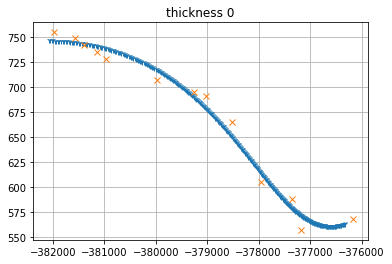

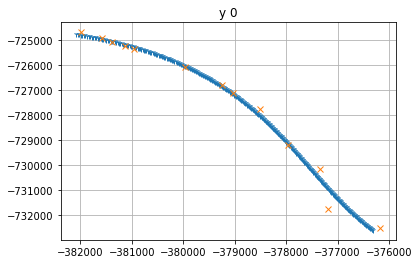

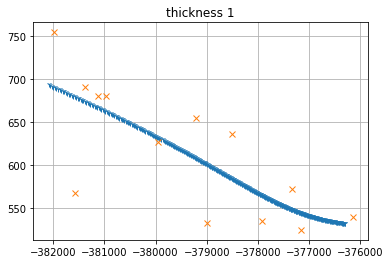

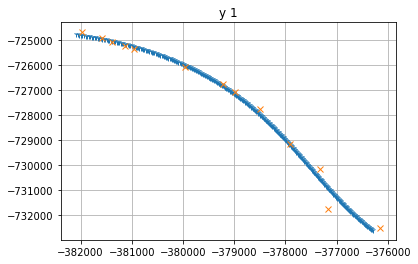

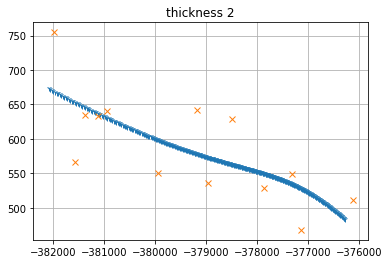

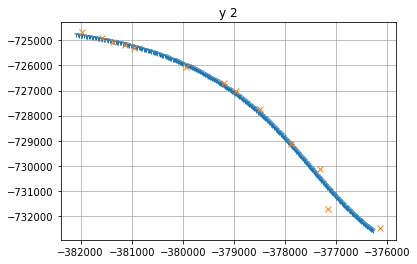

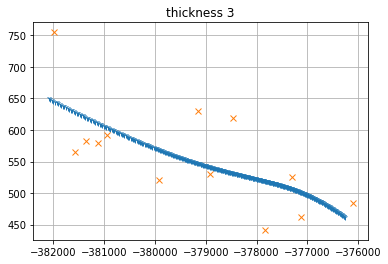

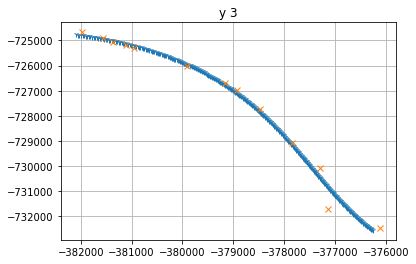

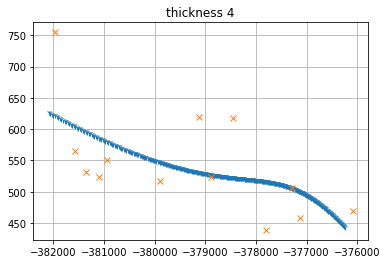

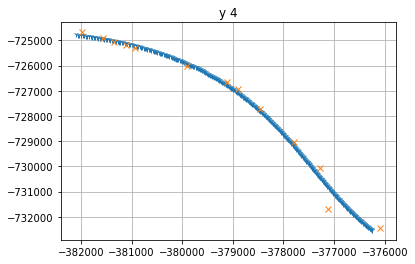

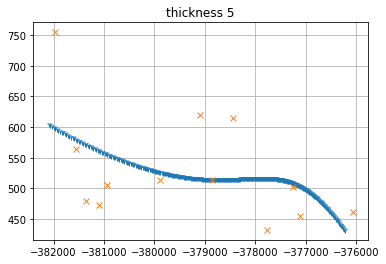

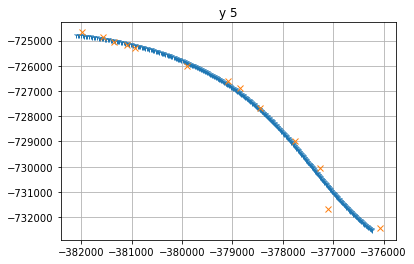

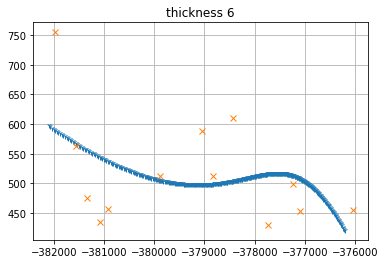

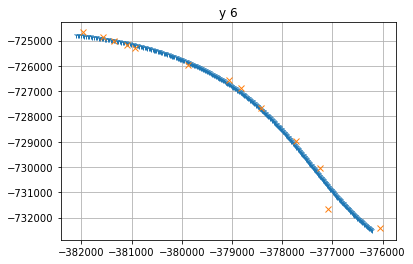

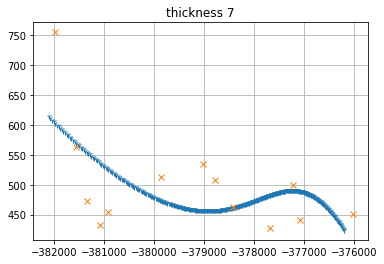

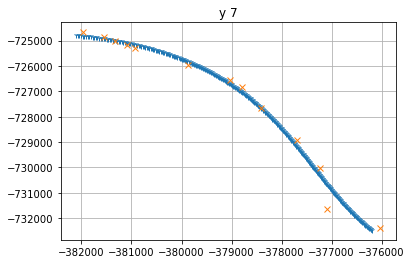

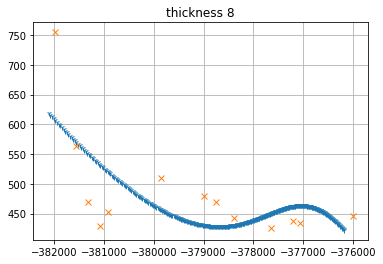

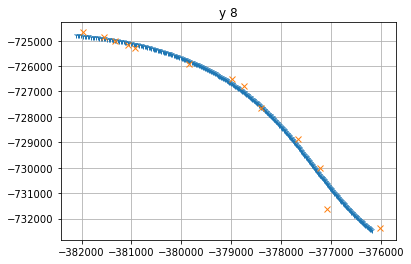

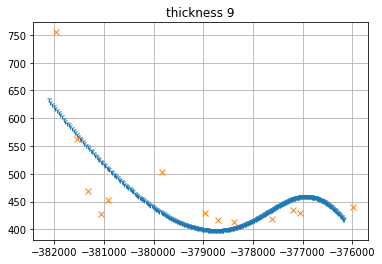

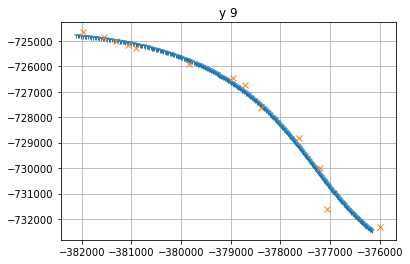

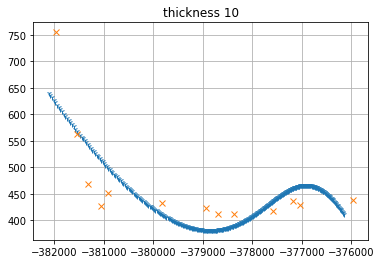

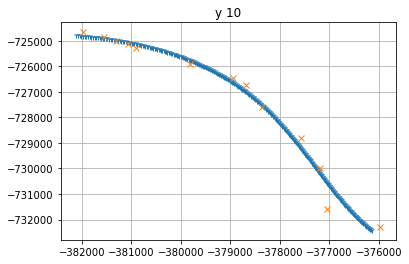

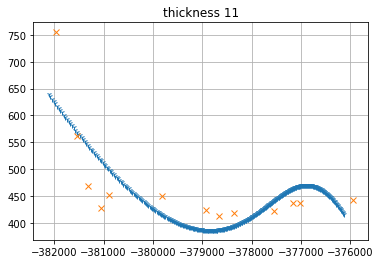

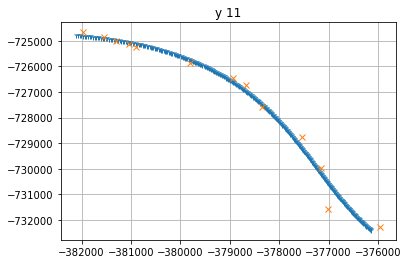

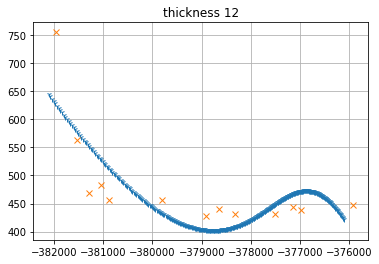

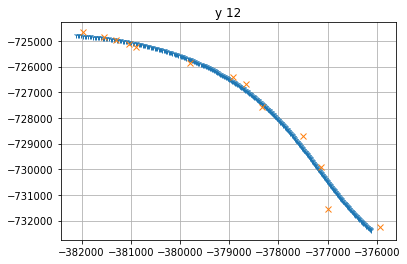

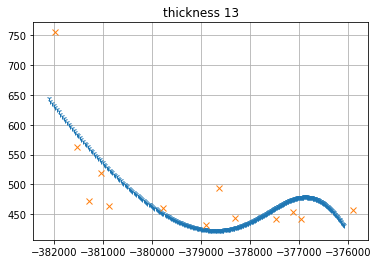

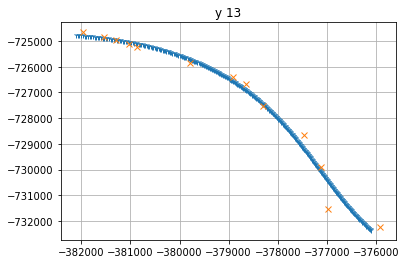

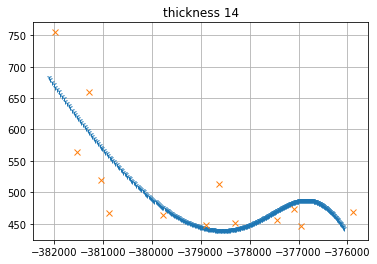

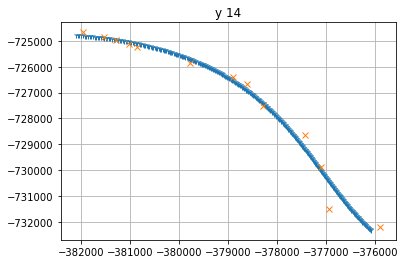

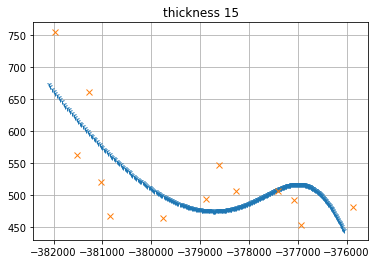

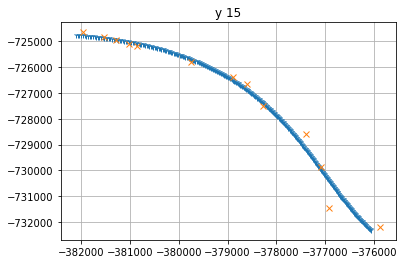

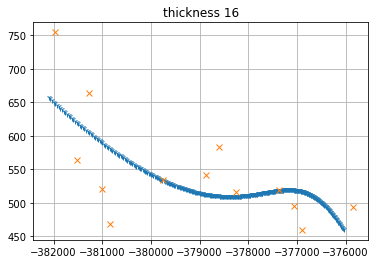

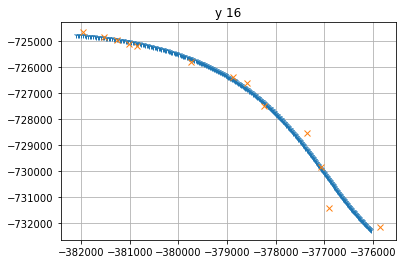

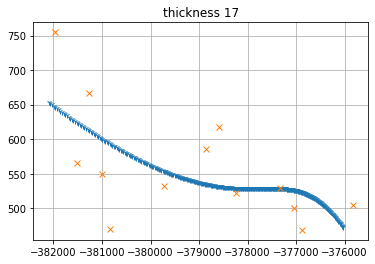

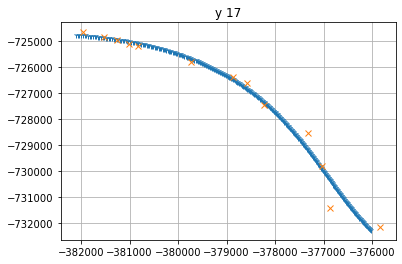

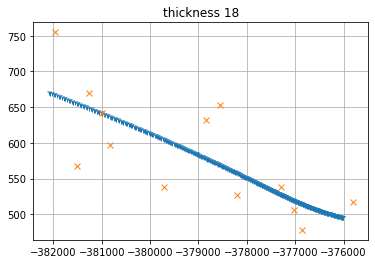

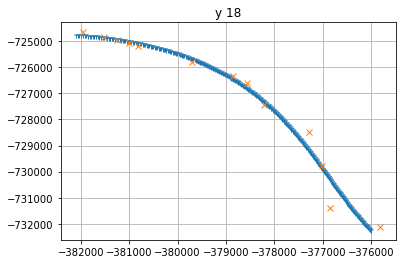

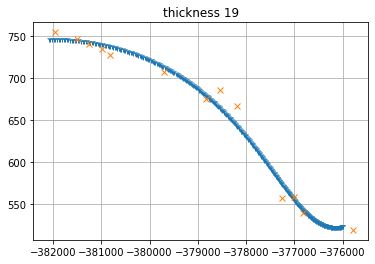

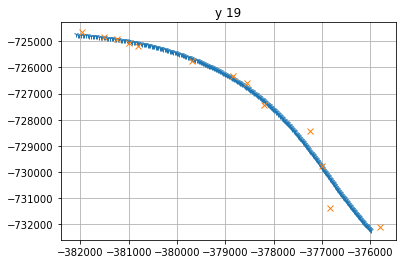

In [164]:
for i in range(distance_downchan.shape[0]):
    
    x = points_x[i,:]
    y = points_y[i,:]
    it = ice_thickn[i,:]
    cc = cross_chan_dist[i,:]
    d = distance_downchan[i,:]
    
    
    s = 300000

    #get tck for spline
    x_tck = sp.interpolate.splrep(d, x,s=s)
    y_tck = sp.interpolate.splrep(d, y,s=s)
    it_tck = sp.interpolate.splrep(d, it,s=s)
    cc_tck = sp.interpolate.splrep(d, cc,s=s)
    
#     choose new points to interp at 
    d_new = np.linspace(distance_downchan[i,:][0],distance_downchan[i,:][-1],new_length)
    
    
#     interpolate values
    x_new = sp.interpolate.splev(d_new, x_tck, der=0)
    y_new = sp.interpolate.splev(d_new, y_tck, der=0)
    it_new = sp.interpolate.splev(d_new, it_tck, der=0)
    cc_new  = sp.interpolate.splev(d_new, cc_tck, der=0)
    
    points_y_new[i,:] = y_new
    points_x_new[i,:] = x_new
    ice_thickn_new[i,:] = it_new
    cross_chan_dist_new[i,:] = cc_new
    distance_downchan_new[i,:] = d_new
    
    plt.figure()
    plt.plot(x_new,it_new,'1')
    plt.plot(x,it,'x')
    plt.grid()
    plt.title(f'thickness {i}')
    plt.show()
    
    plt.figure()
    plt.plot(x_new,y_new,'1')
    plt.plot(x,y,'x')
    plt.grid()
    plt.title(f'y {i}')
    plt.show()

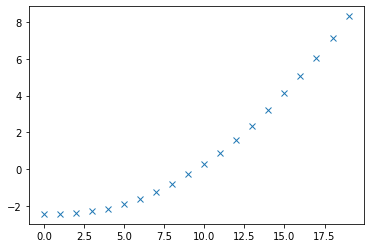

In [165]:
plt.plot(cross_chan_dist_new[:,0],'x')

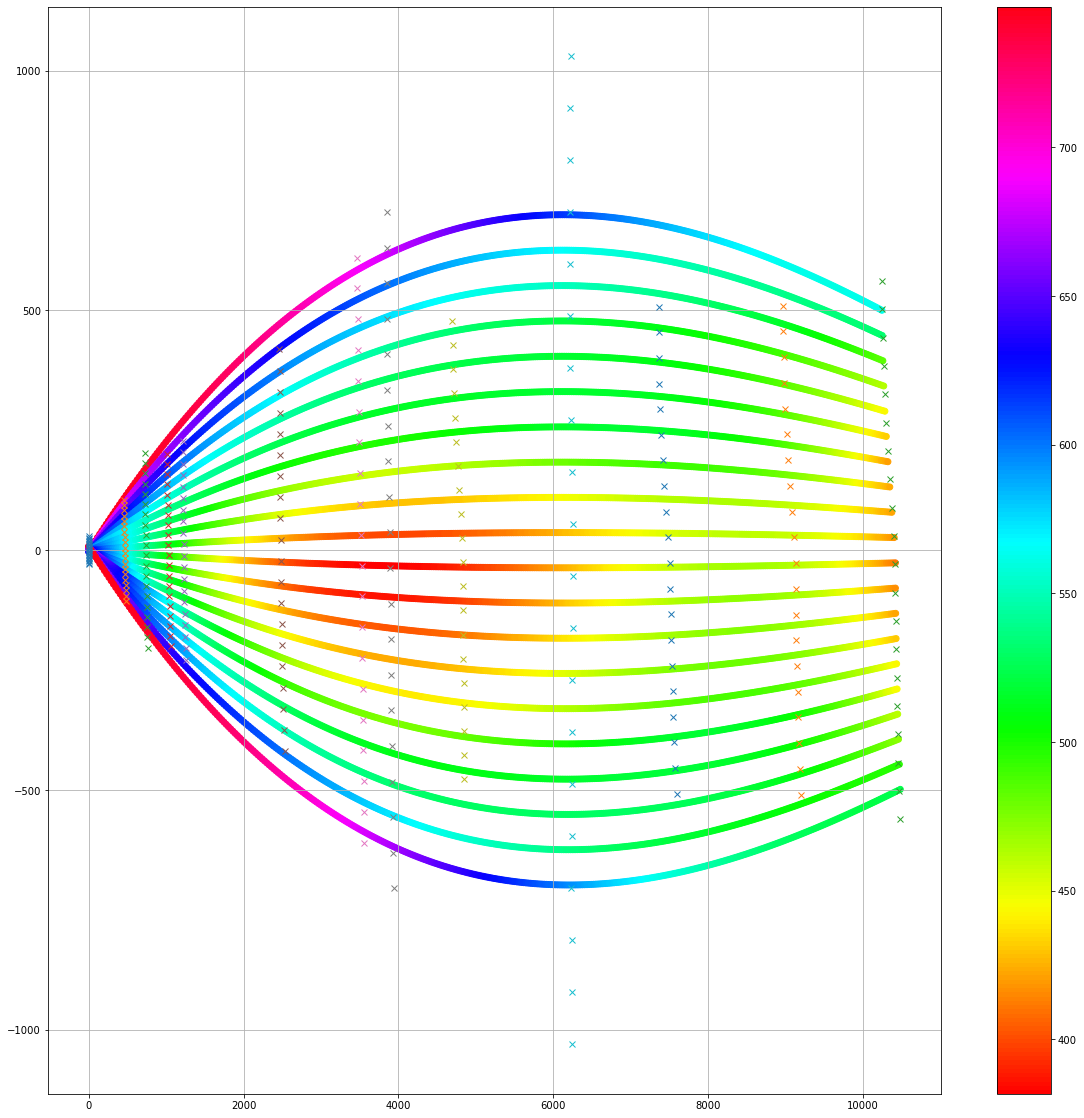

In [169]:
plt.figure(figsize=(20,20))
plt.scatter(distance_downchan_new,cross_chan_dist_new,c=ice_thickn_new,cmap='hsv')
plt.plot(distance_downchan,cross_chan_dist,'x')
# plt.plot(gdf.x,gdf.y,'.')
# plt.xlim([0,1000])
# plt.ylim([-200,200])
plt.colorbar()
plt.grid()

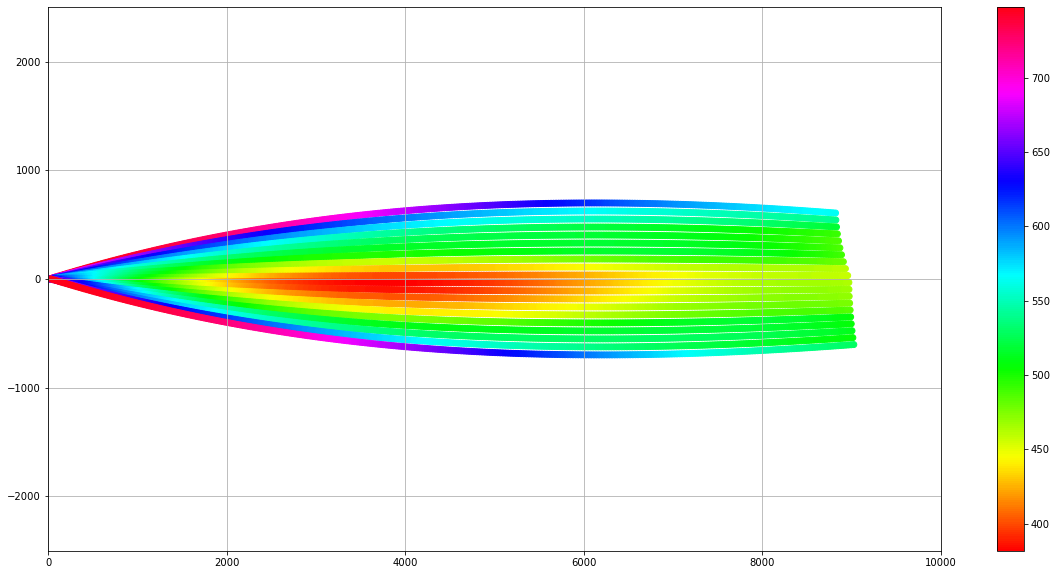

In [224]:
#So discard the first 1 column, and last 10
dc = 1 #discard column

ddn = distance_downchan_new[:,dc:-50]
ccn = cross_chan_dist_new[:,dc:-50]
itn = ice_thickn_new[:,dc:-50]
xn = points_x_new[:,dc:-50]
yn = points_y_new[:,dc:-50]


plt.figure(figsize=(20,10))
plt.scatter(ddn,ccn,c=itn,cmap='hsv')
# plt.plot(distance_downchan,cross_chan_dist,'x')
# plt.plot(gdf.x,gdf.y,'.')
plt.xlim([0,10000])
plt.ylim([-2500,2500])
plt.colorbar()
plt.grid()

In [252]:
chan_df = pd.DataFrame({'down_chan_distance': ddn.flatten(),'cross_chan_distance': ccn.flatten(),'x': xn.flatten(),'y': yn.flatten(),'ice_thickn': itn.flatten()}) #.sort_values(by=['x','y'])
points = [Point(xy) for xy in zip(chan_df.x,chan_df.y)]
chan_gdf = gpd.GeoDataFrame(chan_df,geometry=points,crs="EPSG:3031")

# convert ice_thickness to ice_base_elevation

In [255]:
# Sample REMA tiff at locations
REMA_path = '/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif'
with rio.open(REMA_path) as src:
    
    coords = [(x,y) for x, y in zip(chan_gdf.x.tolist(), chan_gdf.y.tolist())]

    surf_elevations = [elevation[0] for elevation in src.sample(coords)]
    
chan_df['surf'] = surf_elevations
chan_df['ice_base'] = chan_df.surf - chan_df.ice_thickn 

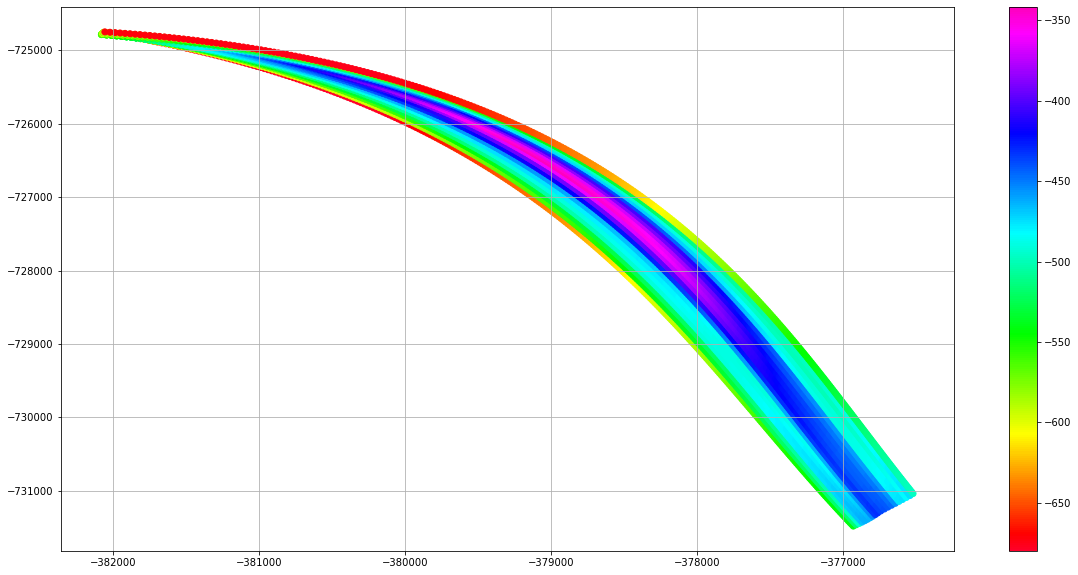

In [256]:
plt.figure(figsize=(20,10))
plt.scatter(chan_df.x,chan_df.y,c=chan_df.ice_base,cmap='gist_rainbow')
# plt.plot(distance_downchan,cross_chan_dist,'x')
# plt.plot(gdf.x,gdf.y,'.')
# plt.xlim([0,10000])
# plt.ylim([-2500,2500])
plt.colorbar()
plt.grid()

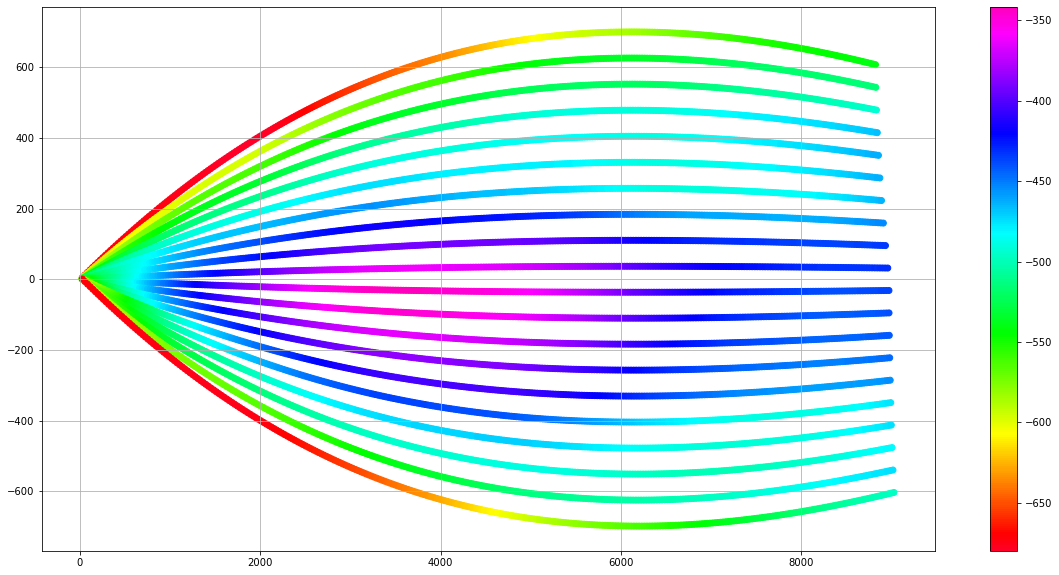

In [257]:
plt.figure(figsize=(20,10))
plt.scatter(chan_df.down_chan_distance,chan_df.cross_chan_distance,c=chan_df.ice_base,cmap='gist_rainbow')
plt.colorbar()
plt.grid()

In [258]:
ibn = chan_df.ice_base.to_numpy().reshape(ddn.shape)
# ddn = chan_df.down_chan_distance.to_numpy().reshape(itn.shape)

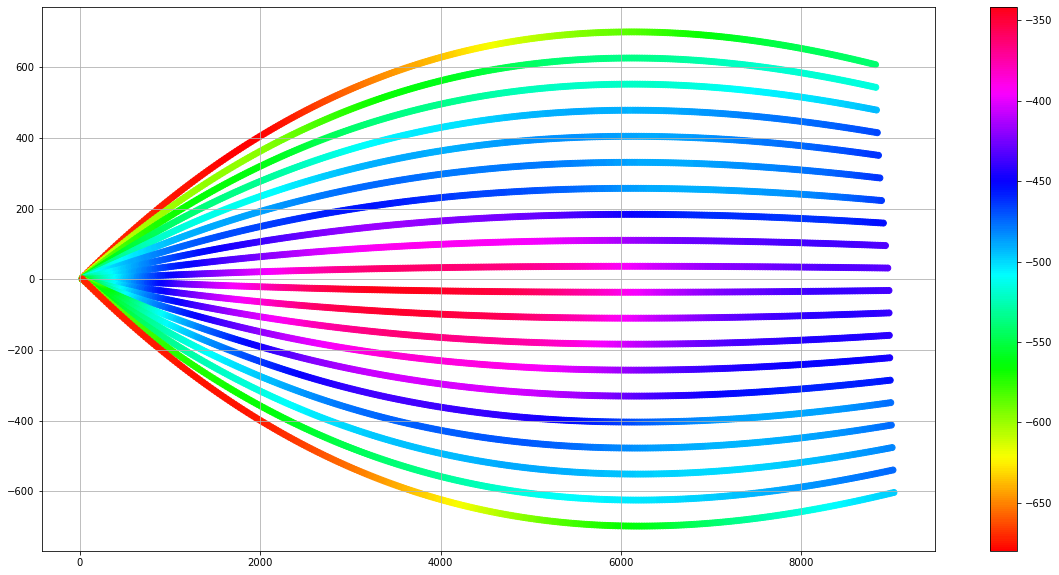

In [259]:
plt.figure(figsize=(20,10))
plt.scatter(ddn,ccn,c=ibn,cmap='hsv')
# plt.plot(distance_downchan,cross_chan_dist,'x')
# plt.plot(gdf.x,gdf.y,'.')
# plt.xlim([0,10000])
# plt.ylim([-2500,2500])
plt.colorbar()
plt.grid()

## now designate ice base elevation outside channel

assume outside the channel is the same thickness as edge

In [260]:
floor = chan_df.ice_base.min()

In [261]:
n_outside_points = 20

In [280]:
ib_outside_chan_a = np.linspace(floor*np.ones(ibn[0,:].shape),ibn[0,:],n_outside_points)
ib_outside_chan_b = np.linspace( ibn[-1,:],floor*np.ones(ibn[-1,:].shape),n_outside_points)

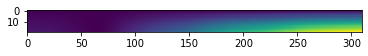

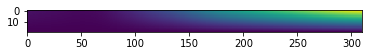

In [282]:
plt.imshow(ib_outside_chan_a)
plt.show()
plt.imshow(ib_outside_chan_b)
plt.show()

In [285]:
dd_outside_chan_a = np.tile(ddn[0,:],(n_outside_points,1)) 
dd_outside_chan_b = np.tile(ddn[-1,:],(n_outside_points,1))

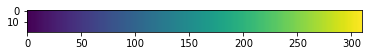

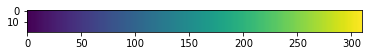

In [286]:
plt.imshow(dd_outside_chan_a)
plt.show()
plt.imshow(dd_outside_chan_b)
plt.show()

In [291]:
cc_outside_chan_a = np.linspace(1000*np.ones(ccn[0,:].shape),ccn[0,:],n_outside_points)
cc_outside_chan_b =   np.linspace( ccn[-1,:],-1000*np.ones(ccn[-1,:].shape),n_outside_points)

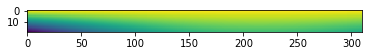

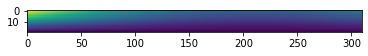

In [292]:
plt.imshow(cc_outside_chan_a)
plt.show()
plt.imshow(cc_outside_chan_b)
plt.show()

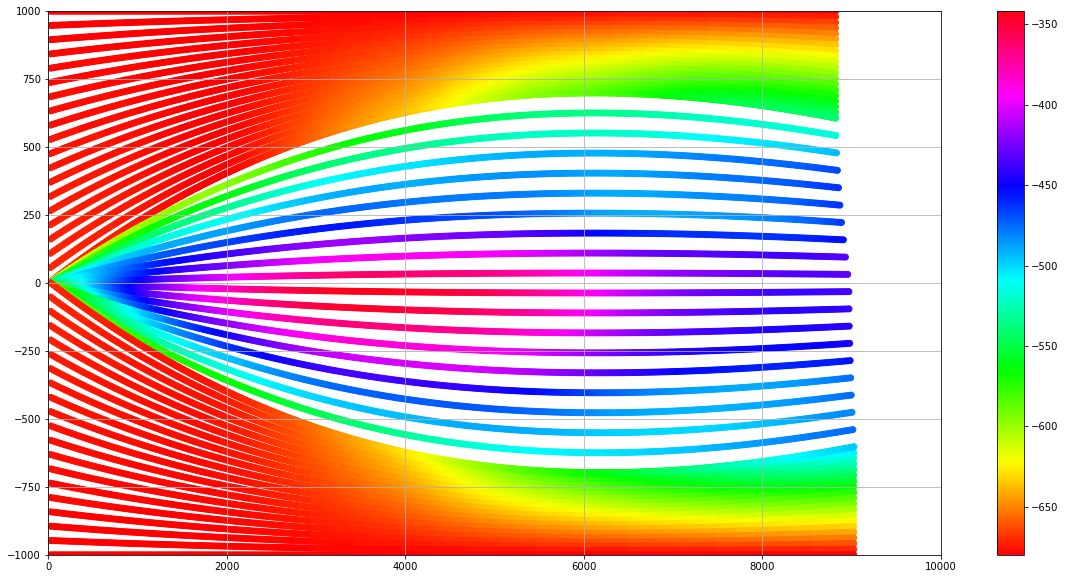

In [293]:
plt.figure(figsize=(20,10))

vmin=np.min(ibn)
vmax=np.max(ibn)

plt.scatter(dd_outside_chan_a,cc_outside_chan_a,c=ib_outside_chan_a,vmin=vmin,vmax=vmax,cmap='hsv')
plt.scatter(dd_outside_chan_b,cc_outside_chan_b,c=ib_outside_chan_b,vmin=vmin,vmax=vmax,cmap='hsv')
plt.scatter(ddn,ccn,c=ibn,vmin=vmin,vmax=vmax,cmap='hsv')
# plt.plot(distance_downchan,cross_chan_dist,'x')
# plt.plot(gdf.x,gdf.y,'.')
plt.xlim([0000,10000])
plt.ylim([-1000,1000])
plt.colorbar()
plt.grid()

In [294]:
dd = np.vstack( (dd_outside_chan_a,ddn,dd_outside_chan_b) )
cc = np.vstack( (cc_outside_chan_a,ccn,cc_outside_chan_b) )
ib = np.vstack( (ib_outside_chan_a,ibn,ib_outside_chan_b) )

# griddit

In [304]:
ddres = 10000
ccres = 3000

extent = [dd.min(),dd.max(),cc.min(),cc.max()]

x = np.linspace(extent[0],extent[1], ddres)
y = np.linspace(extent[3],extent[2], ccres)
# x = np.arange(round(extent[0]),round(extent[1]), 2)
# y = np.flipud(np.arange(round(extent[2]),round(extent[3]), 2))

xv, yv = np.meshgrid(x ,y ) 

In [305]:
points = np.vstack((dd.flatten(),cc.flatten())).T

In [306]:
ib_gridded = sp.interpolate.griddata(points,ib.flatten(),(xv, yv),method='nearest')

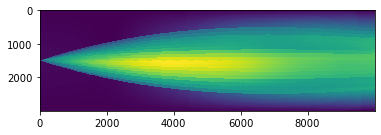

In [307]:
plt.imshow(ib_gridded)

In [309]:
from scipy.io import savemat
out_dic = {"xv": xv, "yv": yv, "ice_base": ib_gridded}

savemat('/Volumes/arc_02/whitefar/MODELLING/channel_shape/try0.mat', out_dic)

In [ ]:
smooth = 300000,down_channel_res = 10000,cross_channel_res = 3000

# make a function of the whole thing

In [347]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from scipy.io import savemat


from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

def make_channel_shape(smooth,down_channel_res,cross_channel_res,
                       discard_column_left = 1,discard_column_right = 50,plotit=True):

#load data

    bed = np.load('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/bed.npy')
    points_x = np.load('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/points_x.npy')
    points_y = np.load('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/points_y.npy')
    distance_downchan = np.load('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/distance_downchan.npy')
    cross_chan_dist = np.load('/Volumes/arc_02/whitefar/MODELLING/channel_shape/input_data/cross_chan_dist.npy')

#make arrays for new points
    number_of_new_points = 29 # number_of_new_points to interpolate between existing points
    new_length =  number_of_new_points*(points_x.shape[1]-1)+points_x.shape[1]  
    bed_new = np.zeros([bed.shape[0], new_length])
    points_x_new = bed_new.copy()
    points_y_new = bed_new.copy()
    distance_downchan_new = bed_new.copy()
    cross_chan_dist_new = bed_new.copy()

#interpolate the channel with line2line method    
    for i in range(distance_downchan.shape[0]):

        b = bed[i,:]
        cc = cross_chan_dist[i,:]
        dd = distance_downchan[i,:]

        #get tck for spline
        b_tck = sp.interpolate.splrep(d, b,s=smooth)
        cc_tck = sp.interpolate.splrep(d, cc,s=smooth)

#choose new points to interp at 
        dd_new = np.linspace(distance_downchan[i,:][0],distance_downchan[i,:][-1],new_length)


#interpolate values
        b_new = sp.interpolate.splev(d_new, b_tck, der=0)
        cc_new  = sp.interpolate.splev(d_new, cc_tck, der=0)

        bed_new[i,:] = b_new
        cross_chan_dist_new[i,:] = cc_new
        distance_downchan_new[i,:] = d_new


#So discard the first 1 column, and last 10
    dc = discard_column_left
    dcr = discard_column_right

    ddn = distance_downchan_new[:,dc:-dcr]
    ccn = cross_chan_dist_new[:,dc:-dcr]
    bn = bed_new[:,dc:-dcr]
    xn = points_x_new[:,dc:-dcr]
    yn = points_y_new[:,dc:-dcr]

    # ## now designate ice base elevation outside channel
    # 
    # assume outside the channel is the same thickness as edge

    floor = chan_df.ice_base.min()

    n_outside_points = 20

    ib_outside_chan_a = np.linspace(floor*np.ones(bn[0,:].shape),bn[0,:],n_outside_points)
    ib_outside_chan_b = np.linspace( bn[-1,:],floor*np.ones(bn[-1,:].shape),n_outside_points)


    dd_outside_chan_a = np.tile(ddn[0,:],(n_outside_points,1)) 
    dd_outside_chan_b = np.tile(ddn[-1,:],(n_outside_points,1))
    
    cc_max = np.round(np.max(ccn)/100)*100 + 100

    cc_outside_chan_a = np.linspace(cc_max*np.ones(ccn[0,:].shape),ccn[0,:],n_outside_points)
    cc_outside_chan_b =   np.linspace( ccn[-1,:],-cc_max*np.ones(ccn[-1,:].shape),n_outside_points)

    dd = np.vstack( (dd_outside_chan_a,ddn,dd_outside_chan_b) ) #distance down
    cc = np.vstack( (cc_outside_chan_a,ccn,cc_outside_chan_b) ) #cros channel
    ib = np.vstack( (ib_outside_chan_a,ibn,ib_outside_chan_b) ) #ice base / ice bed


# # griddit

    extent = [dd.min(),dd.max(),cc.min(),cc.max()]

    x = np.linspace(extent[0],extent[1], down_channel_res)
    y = np.linspace(extent[3],extent[2], cross_channel_res)

    xv, yv = np.meshgrid(x ,y ) 

    points = np.vstack((dd.flatten(),cc.flatten())).T

    ib_gridded = sp.interpolate.griddata(points,ib.flatten(),(xv, yv),method='nearest')
    
    out_dic = {"xv": xv, "yv": yv, "ice_base": ib_gridded}

    savemat(f'/Volumes/arc_02/whitefar/MODELLING/channel_shape/channelshape_s{smooth}_dcr{down_channel_res}_ccr{cross_channel_res}.mat', out_dic)
    
    if plotit==True:
        plt.figure(figsize=(20,15))
        plt.imshow(ib_gridded)
        plt.colorbar()
        plt.show()


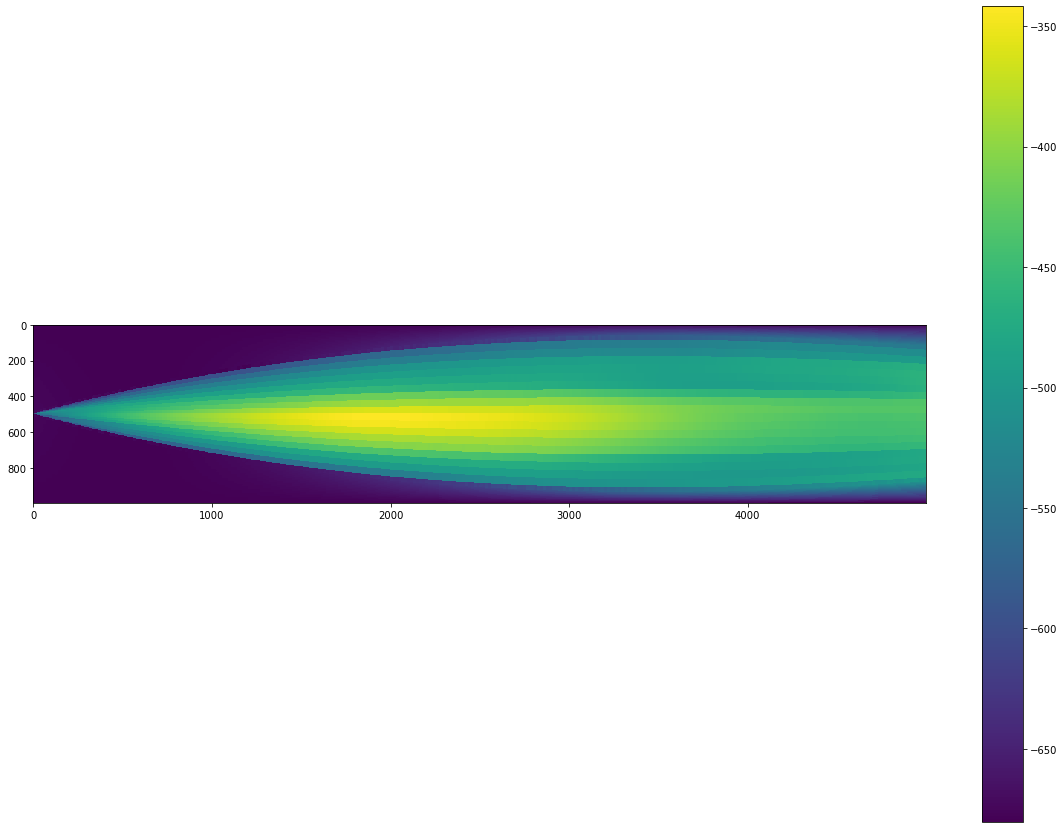

In [351]:
make_channel_shape(smooth = 300000,down_channel_res = 5000,cross_channel_res = 1000)

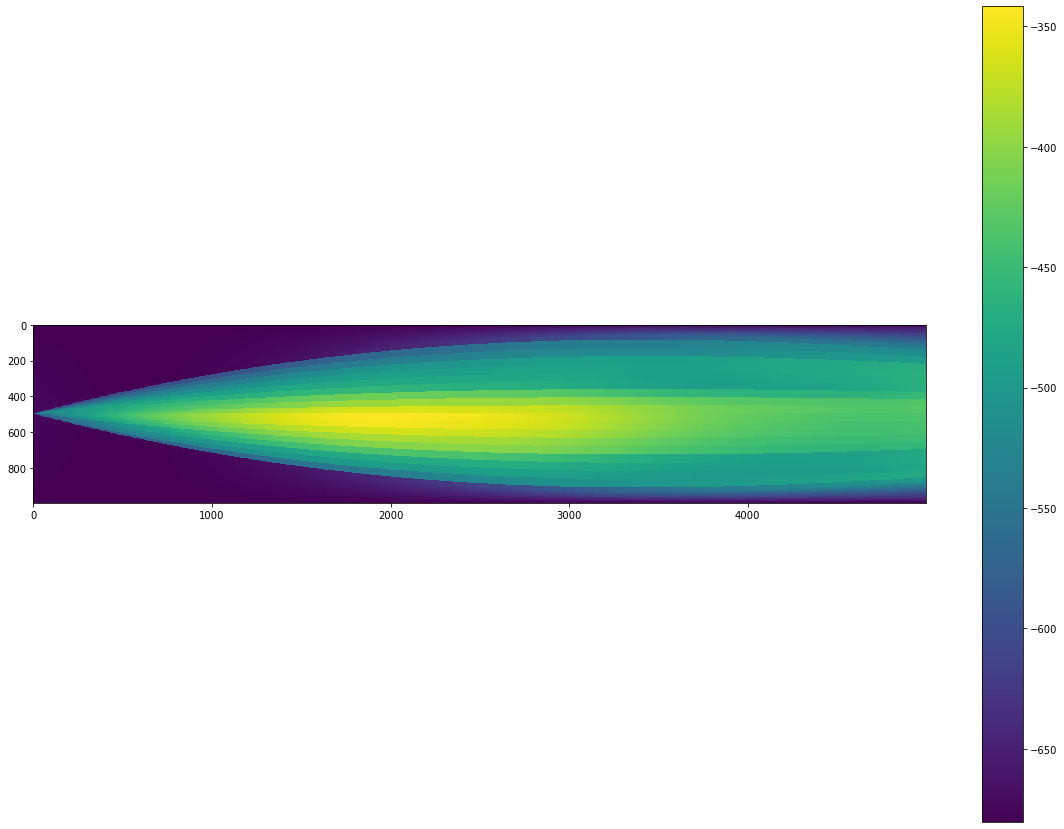

In [352]:
make_channel_shape(smooth = 200000,down_channel_res = 5000,cross_channel_res = 1000)

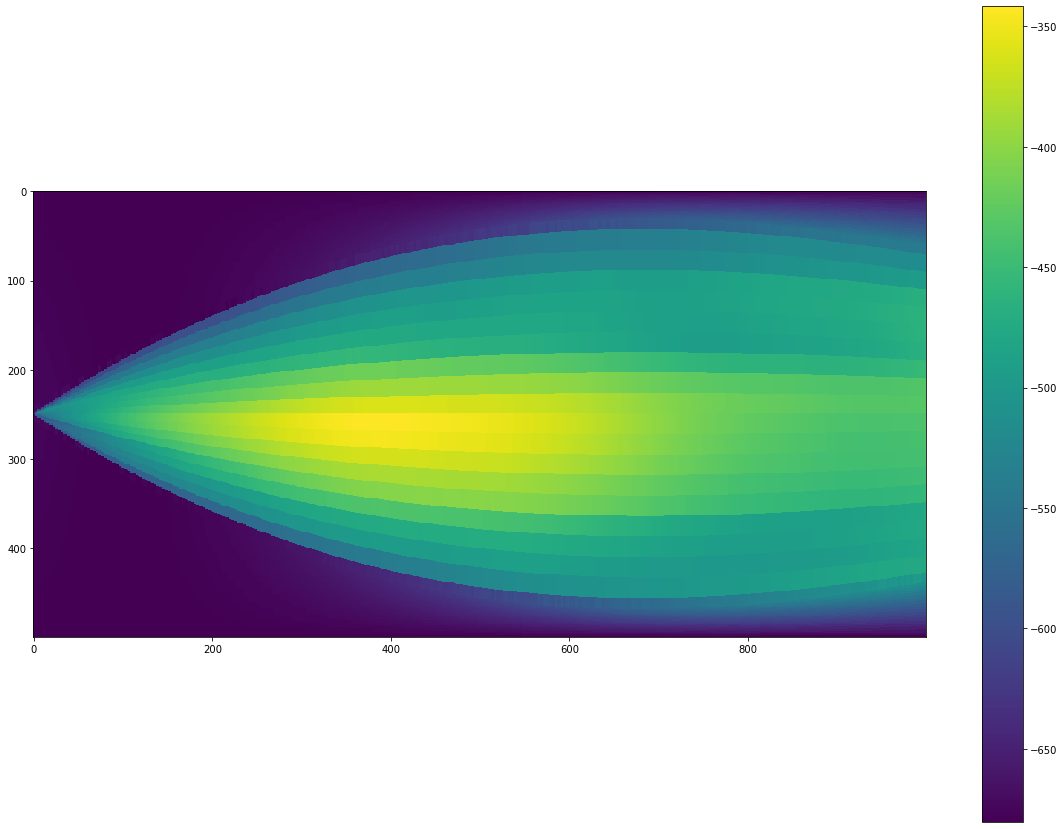

In [355]:
make_channel_shape(smooth = 200000,down_channel_res = 1000,cross_channel_res = 500)

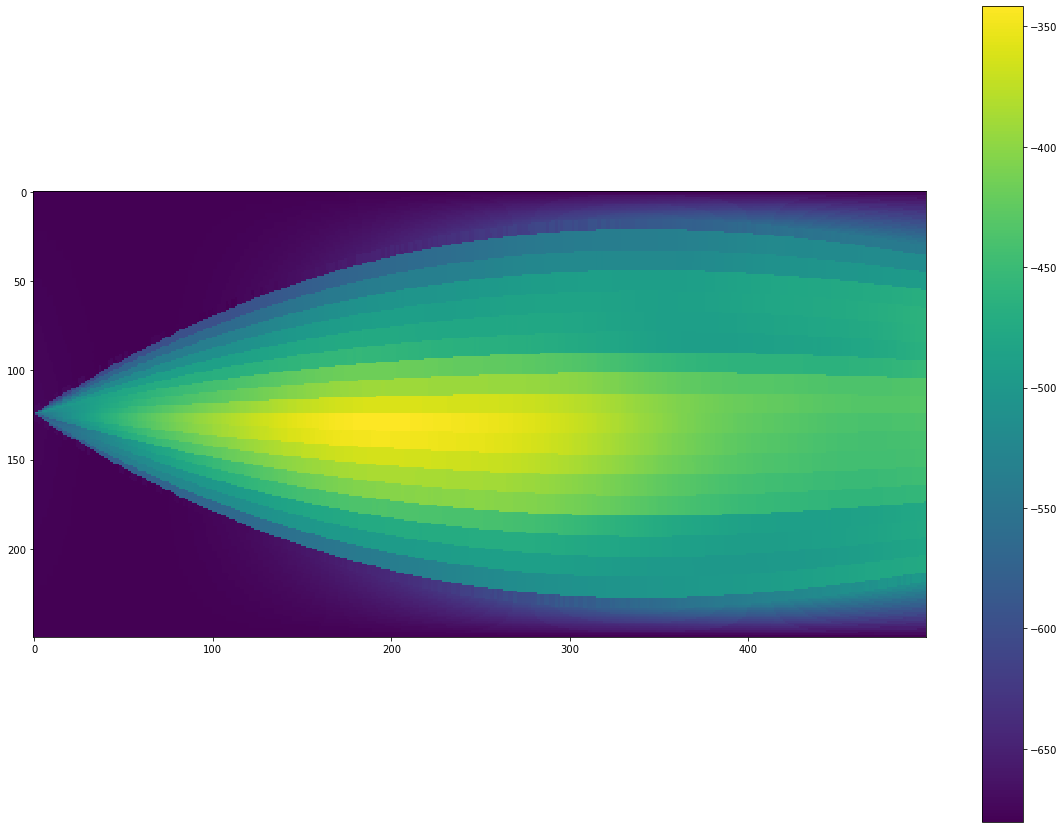

In [356]:
make_channel_shape(smooth = 200000,down_channel_res = 500,cross_channel_res = 250)

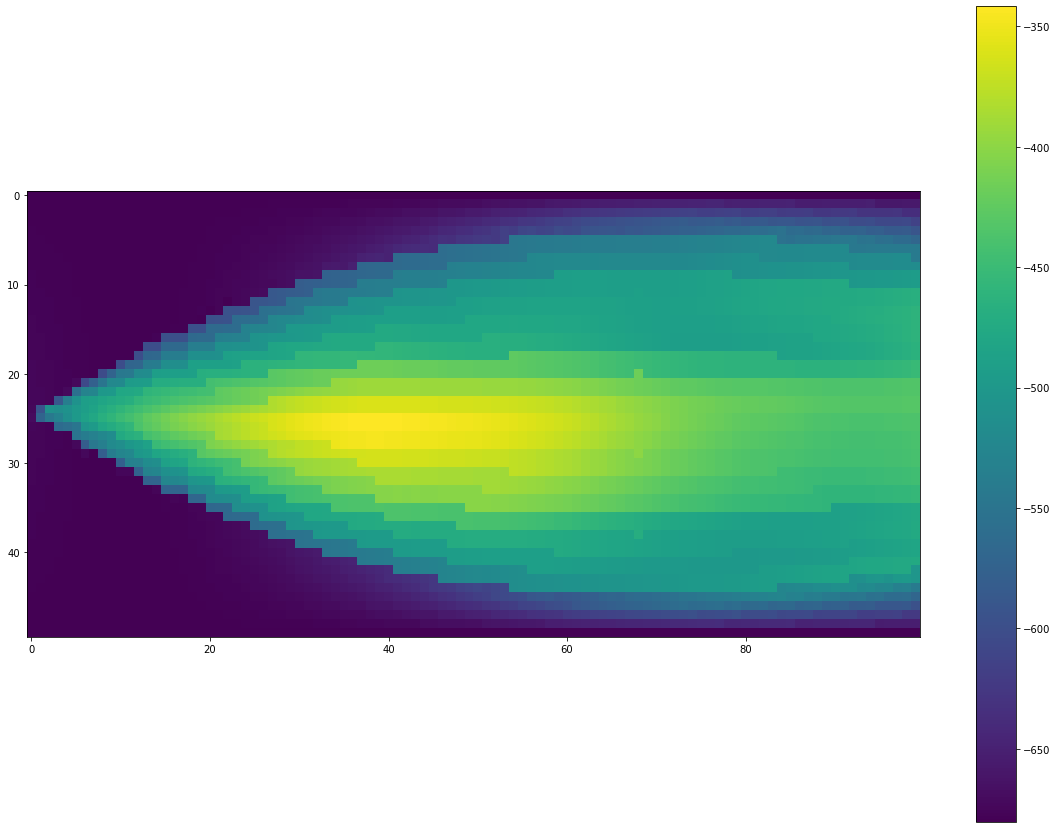

In [357]:
make_channel_shape(smooth = 200000,down_channel_res = 100,cross_channel_res = 50)

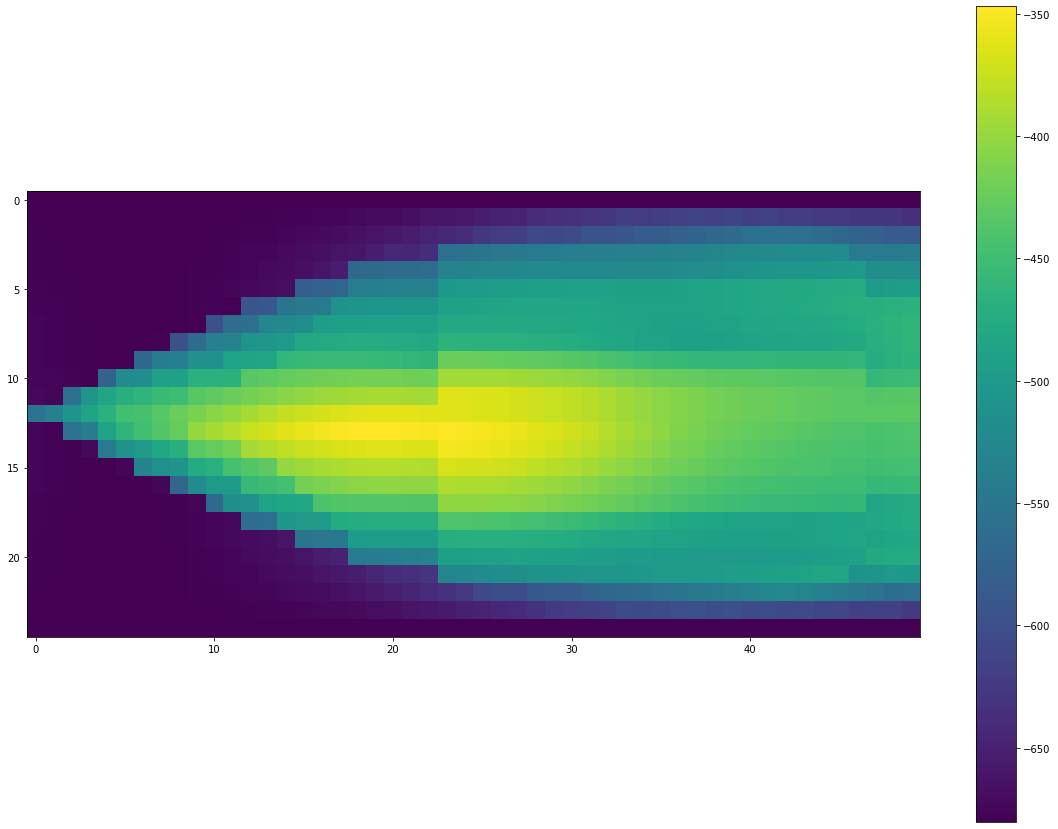

In [358]:
make_channel_shape(smooth = 200000,down_channel_res = 50,cross_channel_res = 25)

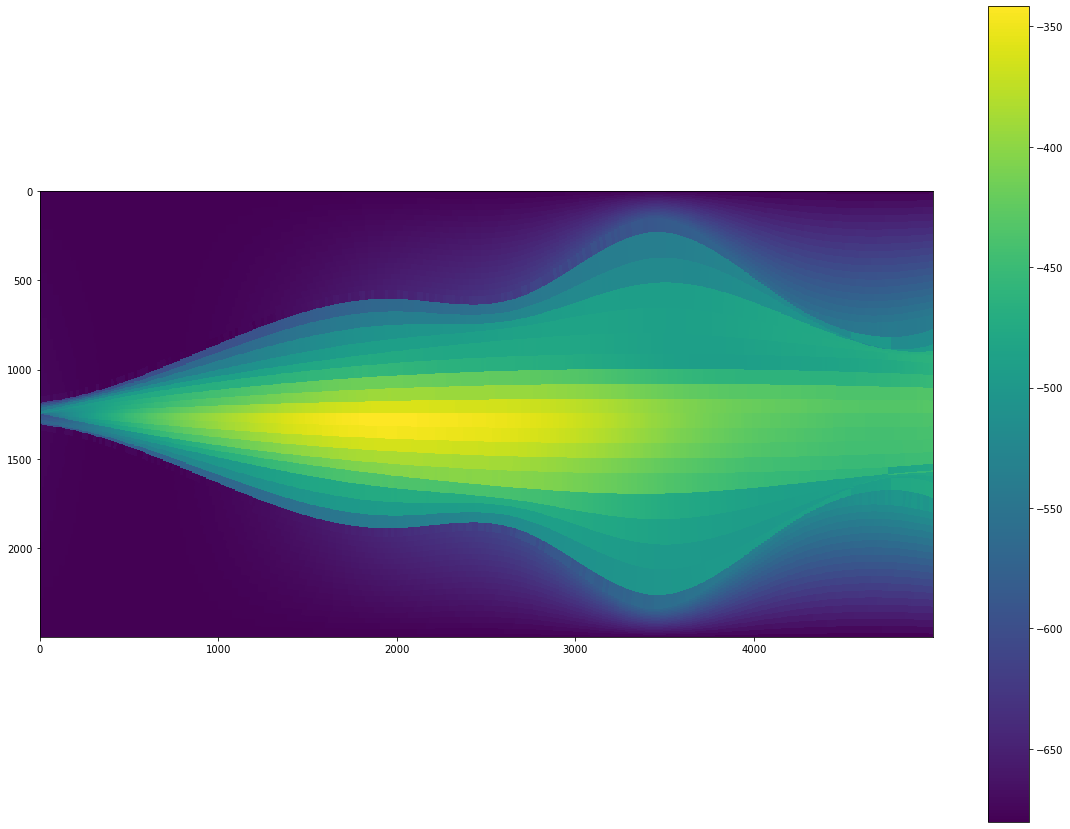

In [362]:
make_channel_shape(smooth = 50000,down_channel_res = 5000,cross_channel_res = 2500)